In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

In [2]:
# loading train balanced data
train_df = pd.read_csv("../data/train_smote_balanced.csv")
test_df = pd.read_csv("../data/test_unbalanced.csv")

In [3]:
#train_df.info()

## Training and Testing

In [4]:
# train data
X_train = train_df.drop('churn_label', axis=1)
y_train = train_df['churn_label']

# test data
X_test = test_df.drop('churn_label', axis=1)
y_test = test_df['churn_label']

## Correlation Heatmap

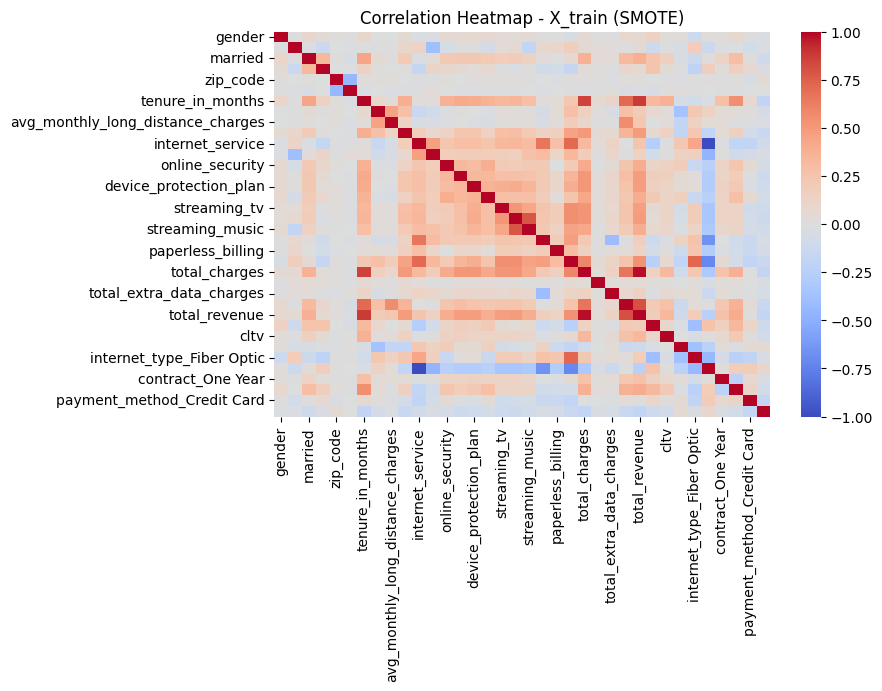

In [5]:
plt.figure(figsize=(8,5))
sns.heatmap(X_train.corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap - X_train (SMOTE)")
plt.show()

In [6]:
# compute correlation matrix
correlation_matrix = X_train.corr()

# extract pairs with high correlation (abs value > 0.8)
high_corr_pairs = (
    correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape),
                                     k = 1).astype(bool))
    .stack()
    .reset_index()
)

# rename columns for clarity
high_corr_pairs.columns = ["Feature_1", "Feature_2", "Correlation"]

# filter for absolute correlations > 0.8
high_corr_pairs = high_corr_pairs[high_corr_pairs["Correlation"].abs() > 0.8]

# Sort by absolute correlation
high_corr_pairs = high_corr_pairs.reindex(
    high_corr_pairs['Correlation'].abs().sort_values(ascending=False).index
)

# Display the result
#pd.set_option('display.max_rows', None)
print(high_corr_pairs)

                       Feature_1                  Feature_2  Correlation
325             internet_service  internet_type_No Internet    -1.000000
542                total_charges              total_revenue     0.977023
214             tenure_in_months              total_revenue     0.877533
210             tenure_in_months              total_charges     0.856404
575  total_long_distance_charges              total_revenue     0.811017


In [7]:
# drop these features
features_to_drop = [
    "internet_type_No Internet",
    "total_charges",
    "total_long_distance_charges",
    "tenure_in_months"
]

X_train.drop(columns=features_to_drop, inplace=True)
X_test.drop(columns=features_to_drop, inplace=True)

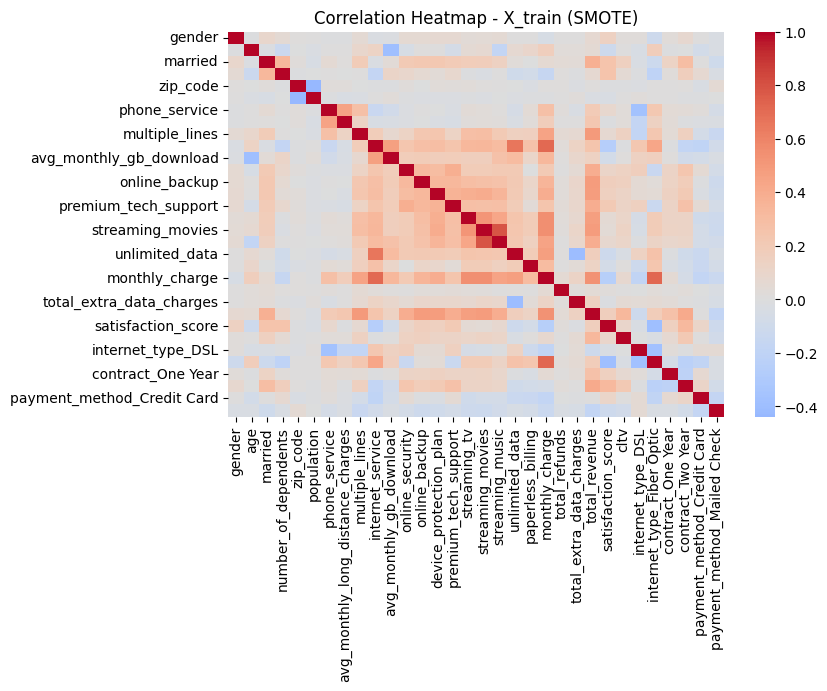

In [8]:
plt.figure(figsize=(8,5))
sns.heatmap(X_train.corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap - X_train (SMOTE)")
plt.show()

## Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression

# initialize and train the model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

/Users/sowmyamaddali/Desktop/Sowmya/Git/customer-churn-prediction/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=42)

### Make Predictions on the Test Set

In [10]:
# predict class labels
y_pred = log_reg.predict(X_test)

# predict probabilities for ROC/AUC
y_prob = log_reg.predict_proba(X_test)[:,1]

### Evaluate the Model

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ROC AUC score
auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {auc:.2f}")

Confusion Matrix:
 [[988  47]
 [ 47 327]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      1035
           1       0.87      0.87      0.87       374

    accuracy                           0.93      1409
   macro avg       0.91      0.91      0.91      1409
weighted avg       0.93      0.93      0.93      1409

ROC AUC Score: 0.97


**Insights:**
- **Accuracy:** 0.93
- **Recall for label 0:** 0.95 (few false negatives)
- **Recall for label 1:** 0.87 (few false negatives)
- **F-1 Score for label 1:** 0.87 (good performance, especially for the minority class! This indicates the model not only is catching churn cases well, but it's not over-predicting churn either (which is a common mistake))
- **ROC AUC Score:** 0.97 (model is able to separate the classes)

### Plot the ROC Curve

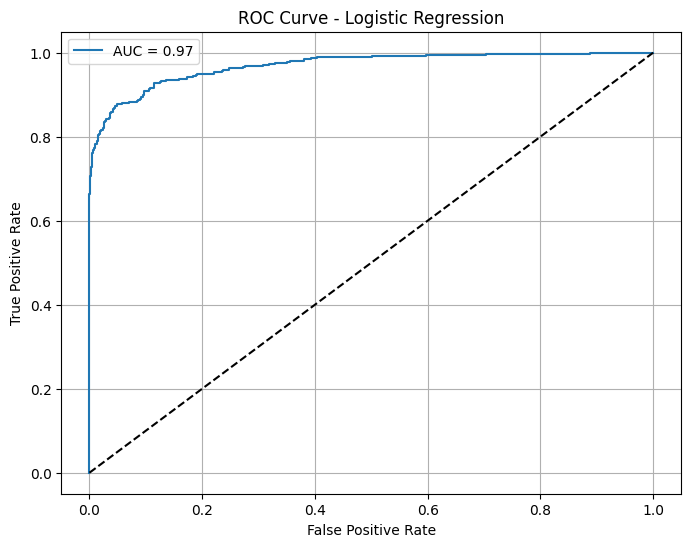

In [12]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
# baseline
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()

## Ridge Classifier

In [14]:
from sklearn.linear_model import RidgeClassifier

'''
`alpha` controls the regularization strength:
1. "Higher alpha = more shrinkage"
2. Default is 1.0
'''
ridge_model = RidgeClassifier(alpha=1.0, random_state=42)
ridge_model.fit(X_train, y_train)

RidgeClassifier(random_state=42)

In [15]:
y_pred_ridge = ridge_model.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ridge))
print("\nClassification Report:\n", classification_report(y_test, y_pred_ridge))

Confusion Matrix:
 [[1008   27]
 [  48  326]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      1035
           1       0.92      0.87      0.90       374

    accuracy                           0.95      1409
   macro avg       0.94      0.92      0.93      1409
weighted avg       0.95      0.95      0.95      1409



**Insights:**
- Both Logistic Regression and Ridge Classifier performed well on the churn prediction task.
- While their recall for the churn class was identical (0.87), Ridge Classifier slightly improved precision for churners and overall accuracy, likely due to L2 regularization stabilizing the coefficients.
- Therefore, Ridge may be slightly better choice in this case, though both models are solid performers.

## Visualizing the co-efficients of both the models

In [16]:
# create a dataframe of coefficients from logistic regression
log_reg_coefs = pd.Series(log_reg.coef_[0],
                          index=X_train.columns).rename("Logistic")

# create a dataframe of coefficients from ridge classifier
ridge_coefs = pd.Series(ridge_model.coef_[0],
                        index=X_train.columns).rename("Ridge")

# combine into a single dataframe for comparision
coef_df = pd.concat([log_reg_coefs, ridge_coefs], axis=1)

In [17]:
# defining how many features to show based on absolute coefficient values
top_n = 15
top_features = coef_df.abs().mean(axis=1).sort_values(ascending=True).head(top_n).index

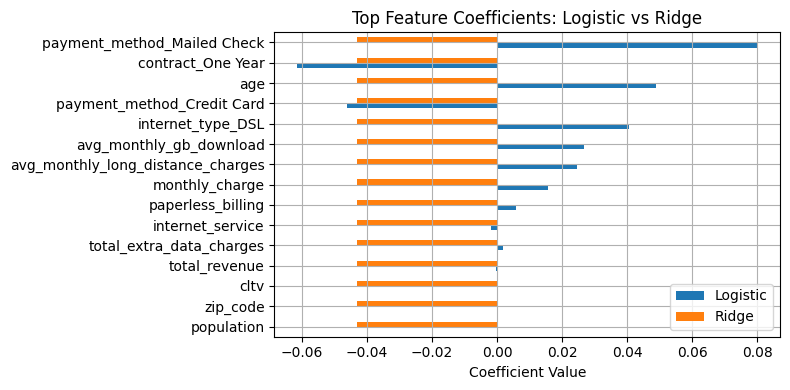

In [18]:
# plot
coef_df.loc[top_features].plot(kind="barh", figsize=(8,4))
plt.title("Top Feature Coefficients: Logistic vs Ridge")
plt.xlabel("Coefficient Value")
plt.grid(True)
plt.tight_layout()
plt.show()